# **Estimating time-varying betas for a panel of stock returns using DCC-GARCH**

This notebook was created as a practical task required for the application to the role of Research Assistant, related to the project "Estimating Dynamic Exposures and Market-Based Stress Testing for Cyber Risks" at Vrije Universiteit Amsterdam. My task was to take any publicly available daily factor and a small panel of stock returns or simulated data, and estimate the time-varying betas to the selected factor using either DCC-GARCH or Kalman filter. Finally, I was to include a note comparing methods and a figure with all beta estimates + 95% CI. The note summarizes my approach, key findings, and any challenges.

In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model

## **Theoretical Background**

In a standard CAPM regression setting, a stock’s excess return is modeled as $r_{i,t} = \alpha_i + \beta_i f_t + \varepsilon_{i,t},$, where the $r_{i,t}$ is the return of stock $i$ at time $t$, $f_t$ is the return of factors (e.g., market, SMB, or cyber-risk index in our case),and $\beta_i$ is the exposure/sensitivity of stock $i$ to factor $f$. Usually, $\beta_i$ is assumed constant over the sample. But exposures shift: banks may become more sensitive to cyber-risk factors after a major incident, then less sensitive later, for example. So, we allow $\beta_{i,t}$ to change over time: $r_{i,t} = \alpha_i + \beta_{i,t} f_t + \varepsilon_{i,t}$, were $\beta_{i,t}$ is the time-varying beta.

There are two common approaches to estimate time-varying betas: DCC-GARCH and Kalman filter. In this short report, I will focus on DCC-GARCH (Dynamic Conditional Correlation - Generalized Autoregressive Conditional Heteroskedasticity) that models the time-varying covariance matrix of multiple return series. If you fit a multivariate DCC-GARCH on stock $r_{i,t}$ and factor $f_t$, you get conditional variance of factor: $\operatorname{Var}_t(f)$, and conditional covariance between stock and factor: $\operatorname{Cov}_t(r_i,f)$. Then
$$
\beta_{i,t} = \frac{\operatorname{Cov}_t(r_i,f)}{\operatorname{Var}_t(f)} \tag{1}
$$
So, the DCC model naturally produces dynamic betas.

## **Data**

As for the factor, I use the market (MKT) factor from the Fama-French 3-Factor model. This is used as a proxy for the overall market return. Using a factor related to cyber-risk would be more relevant to the context of the project, but such data is not easy to obtain. Thus, I proceed with the market factor, which can be accessed through the [Fama-French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html) website. As for the panel of stock, given the context of the project, I consider six banking stocks from the S&P 500 index. The stock data is obtained using the WRDS database, specifically the [CRSP](https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/center-for-research-in-security-prices-crsp/#products) dataset, as the university has a subscription to it. The data spans from June 30, 2015, to June 30, 2025, covering a period of roughly ten years.

**The stocks selected are:** Citigroup (C), JPMorgan Chase (JPM), Bank of America (BAC), Wells Fargo (WFC), Goldman Sachs (GS)

**The factor used is:** market factor $R_m - R_f$ (denoted as MKT)

The data files are included in the repository as `data_ff3.csv` and `data_prices.csv`. After importing the data, I calculate the daily returns for each stock and merge the stock returns with the factor data into a single panel DataFrame. The returns are multiplied by 100 to express them in percentage terms, and to ensure consistency with the factor returns, which are also in percentage terms. The resulting DataFrame has a multi-index with dates and stock tickers, and columns for stock returns and factor returns. 

In [2]:
# Import data –––––
dfPRICES = pd.read_csv('data_prices.csv')
dfFACTORS = pd.read_csv('data_ff3.csv')

# List variables –
lSTOCKS = ['C', 'JPM', 'BAC', 'WFC', 'GS', 'BK']
lFACTORS = ['MKT', 'SMB', 'HML']

In [3]:
# Transform data –––––

# Calculate returns and convert to percentages
dfRETURNS = dfPRICES.copy()
dfRETURNS[lSTOCKS] = dfPRICES[lSTOCKS].pct_change(fill_method=None).mul(100)

# Create panel data in long format
dfPANEL = dfRETURNS.melt(id_vars=['Date'], value_vars=lSTOCKS, var_name='Ticker', value_name='RETURNS')
# Drop missing excess returns values
dfPANEL = dfPANEL.dropna(subset=['RETURNS']).reset_index(drop=True)

# Merge with factors data
dfPANEL = dfPANEL.merge(dfFACTORS, on='Date', how='left')
# Drop rows with missing factor values
dfPANEL = dfPANEL.dropna(subset=lFACTORS).reset_index(drop=True)

# Set multi-index (linearmodels expects (entity, time) order)
dfPANEL = dfPANEL.set_index(['Ticker', 'Date']).sort_index()

## **Estimation**

I start with defining the parameters. I work with an estimation window of 252 trading days (approximately one year), and confidence intervals are computed at the 95% level, as requested. To estimate the time-varying betas, I loop over each stock in the panel. For each stock, I extract its returns and the factor returns, and fit a GARCH(1,1) model using the `arch` library. The GARCH model captures the dynamic correlations between the stock and the factor over time. After fitting the model, I extract the conditional covariance between the stock and the factor, as well as the conditional variance of the factor. Using Equation \ref{eq:time-varying-beta}, I compute the time-varying beta for each stock. I use the standard errors from the GARCH model to compute the 95% confidence intervals for the betas. For comparison, I also compute the OLS beta using the same returns using the `statsmodels` library. As a final step, I store the results in a dictionary for later use.

In [ ]:
# DCC-GARCH estimation –––––

# Define parameters –
iW = 252 # Rolling window for correlation
dCI = 0.95 # Confidence interval level
dZ = norm.ppf(1 - (1 - dCI) / 2) # Z-score for confidence interval

dctRESULTS = {} # To store results

# Loop through each stock –
for s in dfPANEL.index.levels[0]:

    # Get data for the stock and the factor
    dfStock_returns = dfPANEL.loc[s]['RETURNS']
    dfMarket_returns = dfPANEL.loc[s]['MKT']
    dfCombined = dfPANEL.loc[s][['RETURNS', 'MKT']]

    # Fit GARCH model for stock returns
    mdlGARCH_stock = arch_model(dfStock_returns, vol='Garch', p=1, q=1, dist='normal')
    resGARCH_stock = mdlGARCH_stock.fit(disp='off')
    volGARCH_stock = resGARCH_stock.conditional_volatility

    # Fit GARCH model for factor
    mdlGARCH_factor = arch_model(dfMarket_returns, vol='Garch', p=1, q=1, dist='normal')
    resGARCH_factor = mdlGARCH_factor.fit(disp='off')
    volGARCH_factor = resGARCH_factor.conditional_volatility

    # Calculate rolling correlations
    sCORR_rolling = dfCombined['RETURNS'].rolling(iW).corr(dfCombined['MKT'])
    # Fill initial NaN values with overall correlation
    sCORR_overall = dfCombined['RETURNS'].corr(dfCombined['MKT'])
    sCORR_rolling = sCORR_rolling.fillna(sCORR_overall)

    # Calculate time-varying betas
    # Beta_t = Corr_t * (Vol_stock_t / Vol_market_t) using model (1)
    sBETA_t = sCORR_rolling * (volGARCH_stock / volGARCH_factor)


    # Calculate confidence intervals
    # Rolling standard deviation and mean of beta
    sBETA_rolling_std = sBETA_t.rolling(iW).std()
    sBETA_rolling_mean = sBETA_t.rolling(iW).mean()

    # 95% confidence intervals
    sCI_l = sBETA_rolling_mean - 1.96 * sBETA_rolling_std
    sCI_u = sBETA_rolling_mean + 1.96 * sBETA_rolling_std

    # Fill initial NaN values
    sBETA_rolling_std = sBETA_rolling_std.fillna(sBETA_t.std())
    sCI_l = sCI_l.fillna(sBETA_t - dZ * sBETA_t.std())
    sCI_u = sCI_u.fillna(sBETA_t + dZ * sBETA_t.std())

    # Estimate OLS beta for comparison
    mdlOLS = sm.OLS(endog=dfStock_returns,
                       exog=sm.add_constant(dfMarket_returns),
                       missing='drop').fit()
    dBETA_ols = mdlOLS.params['MKT']

    # Store results
    dctRESULTS[s] = {
        'stock': s,
        'beta': sBETA_t,
        'lower_ci': sCI_l,
        'upper_ci': sCI_u,
        'dates': dfStock_returns.index,
        'stock_vol': volGARCH_stock,
        'factor_vol': volGARCH_factor,
        'correlation': sCORR_rolling,
        'stock_garch_result': resGARCH_stock,
        'market_garch_result': resGARCH_factor,
        'ols_beta': dBETA_ols
    }

*A note on the code implementation: this is a one-time estimation for demonstration purposes only, if it used in a regular basis, it should be defined as a function.*

## **Results**

The results of the analysis are presented in Table \ref{tab:comparison-table}. The table compares the constant ($\hat\beta_i$) and time-varying beta ($\hat\beta_{i,t}$) estimates across different stocks. The time-varying beta estimates show a wide range of values, indicating varying levels of systematic risk across stocks. The Figure \ref{tab:time-varying-betas} provides a more nuanced view, capturing changes in risk exposure over time. Whether the beta estimates are statistically significant can be assessed using the confidence intervals.

Applying a new method (in my case DCC-GARCH) always comes with challenges. Understanding the underlying assumptions and limitations of the model is also crucial. In a longer-term project, I would consider comparing the DCC-GARCH results with those obtained from the Kalman filter approach. This comparison would provide insights into the robustness of the time-varying beta estimates and help identify any discrepancies between the two methods.

In [36]:
# Comparison table –––––

# Build the raw DataFrame
dfCOMPARISON = pd.DataFrame({
    'Stock': [dctRESULTS[s]['stock'] for s in dctRESULTS],
    'OLS Beta': [dctRESULTS[s]['ols_beta'] for s in dctRESULTS],
    'Mean': [dctRESULTS[s]['beta'].mean() for s in dctRESULTS],
    'Std': [dctRESULTS[s]['beta'].std() for s in dctRESULTS],
    'Min': [dctRESULTS[s]['beta'].min() for s in dctRESULTS],
    'Max': [dctRESULTS[s]['beta'].max() for s in dctRESULTS],
    'Range': [dctRESULTS[s]['beta'].max() - dctRESULTS[s]['beta'].min() for s in dctRESULTS]
})

# MultiIndex for headers
dfCOMPARISON.columns = pd.MultiIndex.from_tuples([
    ("", "Stock"),
    ("", "Constant Beta"),
    ("Time-Varying Beta", "Mean"),
    ("Time-Varying Beta", "Std"),
    ("Time-Varying Beta", "Min"),
    ("Time-Varying Beta", "Max"),
    ("Time-Varying Beta", "Range")
])

# Format for LaTeX export
dfLatex = dfCOMPARISON.copy()

# Keep Constant Beta separately
dfLatex[("", "Constant Beta")] = dfLatex[("", "Constant Beta")].map("{:.3f}".format)

# Combine Mean + Std into one column
dfLatex[("Time-Varying Beta", "Mean (Std)")] = dfLatex[("Time-Varying Beta", "Mean")].map("{:.3f}".format) + " (" + dfLatex[("Time-Varying Beta", "Std")].map("{:.3f}".format) + ")"

# Combine Min + Max into one column
dfLatex[("Time-Varying Beta", "Min – Max")] = dfLatex[("Time-Varying Beta", "Min")].map("{:.3f}".format) + " – " + dfLatex[("Time-Varying Beta", "Max")].map("{:.3f}".format)

# Keep Range separately
dfLatex[("Time-Varying Beta", "Range")] = dfLatex[("Time-Varying Beta", "Range")].map("{:.3f}".format)

# Drop unused raw columns
dfLatex = dfLatex.drop(columns=[
    ("Time-Varying Beta", "Mean"),
    ("Time-Varying Beta", "Std"),
    ("Time-Varying Beta", "Min"),
    ("Time-Varying Beta", "Max")
])

# Reorder columns explicitly
dfLatex = dfLatex[[
    ("", "Stock"),
    ("", "Constant Beta"),
    ("Time-Varying Beta", "Mean (Std)"),
    ("Time-Varying Beta", "Min – Max"),
    ("Time-Varying Beta", "Range")
]]

# Export to LaTeX
with open('documentation/output/comparison_table.tex', 'w') as f:
    f.write(dfLatex.to_latex(index=False,
                             multicolumn=True,
                             multicolumn_format="c",
                             column_format="lcccc",
                             escape=False,
                             formatters={("", "Stock"): lambda x: r"\textbf{" + str(x) + "}"}
                             ))

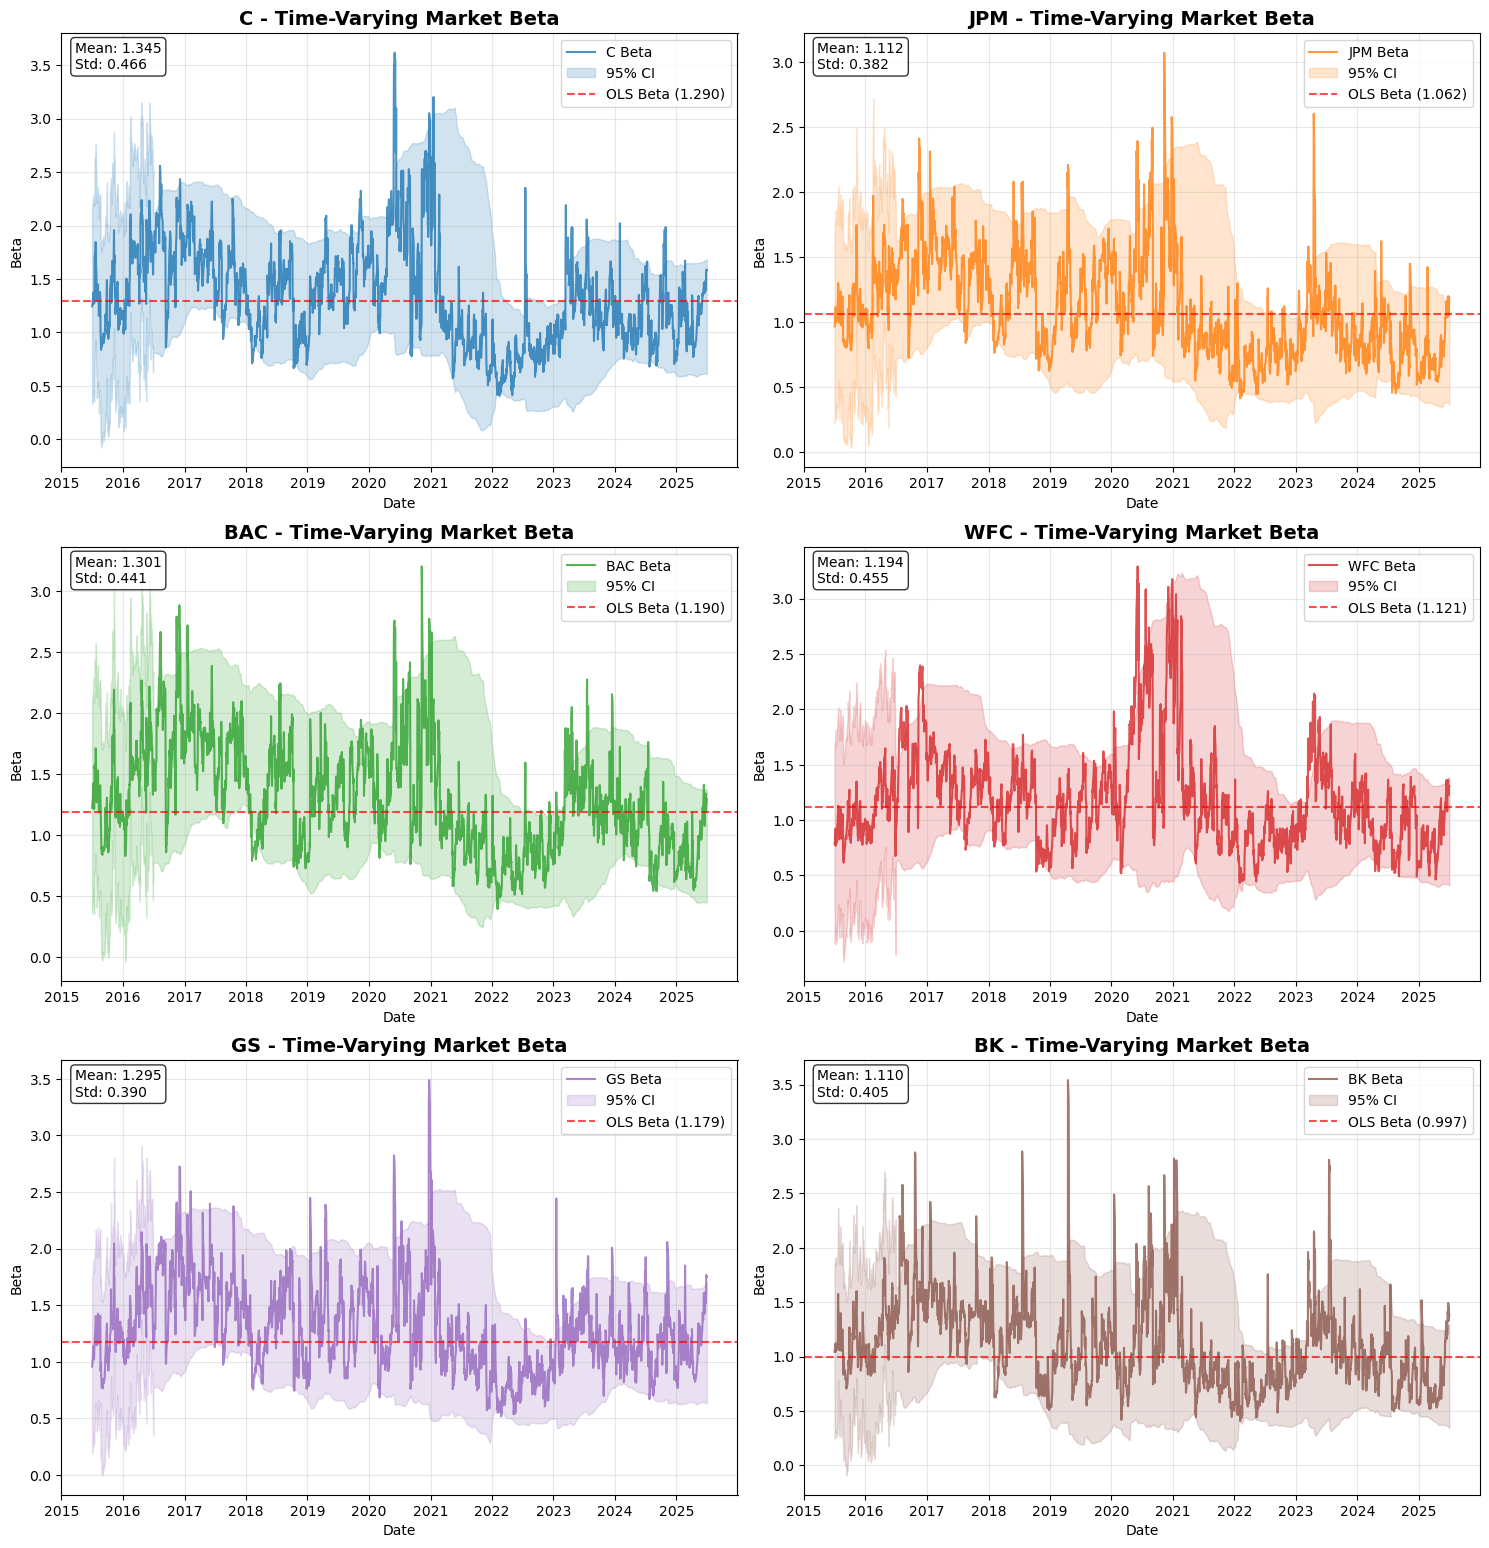

In [43]:
# Visualization of time-varying betas with confidence intervals –––––

# Set up the plot
fig, axes = plt.subplots(3, 2, figsize=(15, 16))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, stock in enumerate(lSTOCKS):
    ax = axes[i]
    result = dctRESULTS[stock]
    
    dates = pd.to_datetime(result['dates'])
    beta = result['beta']

    # Plot time-varying beta
    ax.plot(dates, beta, color=colors[i], linewidth=1.5, label=f'{stock} Beta', alpha=0.8)
    
    # Plot confidence intervals
    ax.fill_between(dates, result['lower_ci'], result['upper_ci'], color=colors[i], alpha=0.2, label='95% CI')
    
    # Plot OLS beta as horizontal line for comparison
    ols_beta = result['ols_beta']
    ax.axhline(y=ols_beta, color='red', linestyle='--', alpha=0.7, 
               label=f'OLS Beta ({ols_beta:.3f})')
    
    # Formatting
    ax.set_title(f'{stock} - Time-Varying Market Beta', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Beta')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add summary statistics as text
    mean_beta = beta.mean()
    std_beta = beta.std()
    ax.text(0.02, 0.98, f'Mean: {mean_beta:.3f}\nStd: {std_beta:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
#plt.suptitle('Time-Varying Factor Betas for Banking Stocks (DCC-GARCH Approach)', 
#             fontsize=16, fontweight='bold', y=0.995)
plt.subplots_adjust(top=0.95)
plt.savefig('documentation/output/time_varying_betas.png', dpi=300)
plt.show()

In [ ]:
# Export python code / markdown cells separately
'''
import nbformat
# Load notebook
nb = nbformat.read("time-varying-betas.ipynb", as_version=4)

# Write code cells into one python script
with open("documentation/time-varying-betas-script.py", "w", encoding="utf-8") as f:
    for cell in nb.cells:
        if cell.cell_type == "code":
            f.write(cell.source.replace("–", "-") + "\n\n")

# Collect markdown cells
md_cells = [cell['source'] for cell in nb.cells if cell['cell_type'] == 'markdown']

# Write them into one markdown file
with open("documentation/time-varying-betas-markdown.md", "w") as f:
    f.write("\n\n".join(md_cells))

# Convert markdown to LaTeX using pandoc
# run in bash
# pandoc documentation/time-varying-betas-markdown.md -o documentation/time-varying-betas-markdown.tex
'''